In [1]:
# Import libraries
!pip install ultralytics
!pip install tqdm
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 18.8 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Set the data directory
DATA_DIR = Path('/kaggle/input/lacuna-malaria-detection-dataset')

# Preview data files available
os.listdir(DATA_DIR)

['SampleSubmission.csv', 'images', 'Train.csv', 'Test.csv']

In [3]:
# Define directories for images and labels
TRAIN_IMAGES_DIR = Path('/kaggle/working/train/images')
VAL_IMAGES_DIR = Path('/kaggle/working/val/images')
TEST_IMAGES_DIR = Path('/kaggle/working/test/images')
TRAIN_LABELS_DIR = Path('/kaggle/working/train/labels')
VAL_LABELS_DIR = Path('/kaggle/working/val/labels')
TEST_LABELS_DIR = Path('/kaggle/working/test/labels')

In [4]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

In [5]:
# Add an image_path column
train['image_path'] = [Path('/kaggle/input/lacuna-malaria-detection-dataset/images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('/kaggle/input/lacuna-malaria-detection-dataset/images/' + x) for x in test.Image_ID]

In [6]:
# Map string classes to integers (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'NEG': 1, 'WBC': 2,})

In [7]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset=['Image_ID'], ignore_index=True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size=0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

In [8]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.674061
 WBC            0.296587
 NEG            0.029352
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.670252
 WBC            0.300840
 NEG            0.028908
 Name: proportion, dtype: float64)

In [9]:
# Check the shapes of training and validation data
print(X_train.shape, X_val.shape)

(17580, 9) (5950, 9)


In [10]:
# Create necessary directories
for DIR in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_LABELS_DIR, TEST_LABELS_DIR]:
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok=True)

In [11]:
# Copy train, val, and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
    shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
    shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
    shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/2060 [00:00<?, ?it/s]

  0%|          | 0/687 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [15]:
def save_yolo_annotation(row):
    # Define label file path
    image_path = row['image_path']
    output_dir = row['output_dir']
    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    # Handle 'NEG' class (assumed as 'class_id' 1)
    if row['class_id'] == 1:
        # Create an empty label file if necessary for 'NEG' class
        with open(label_file, 'w') as f:
            pass  # This creates an empty file
        return  # Exit the function early as no bounding box is required

    # For other classes
    image_path, class_id = row['image_path'], row['class_id']

    # Load the image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    # Get image dimensions
    height, width, _ = img.shape

    # Extract and normalize bounding box coordinates
    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Write the YOLO annotation to the file
    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")


In [16]:
# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

In [17]:
# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

/tmp/ipykernel_30/4250151604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/17580 [00:00<?, ?it/s]

/tmp/ipykernel_30/4250151604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/5950 [00:00<?, ?it/s]

In [18]:
# Create a data.yaml file required by YOLO
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

# Save the data.yaml file
yaml_path = Path('data.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

Plotting id_uv8zibyt2l.jpg with 5 bounding boxes.


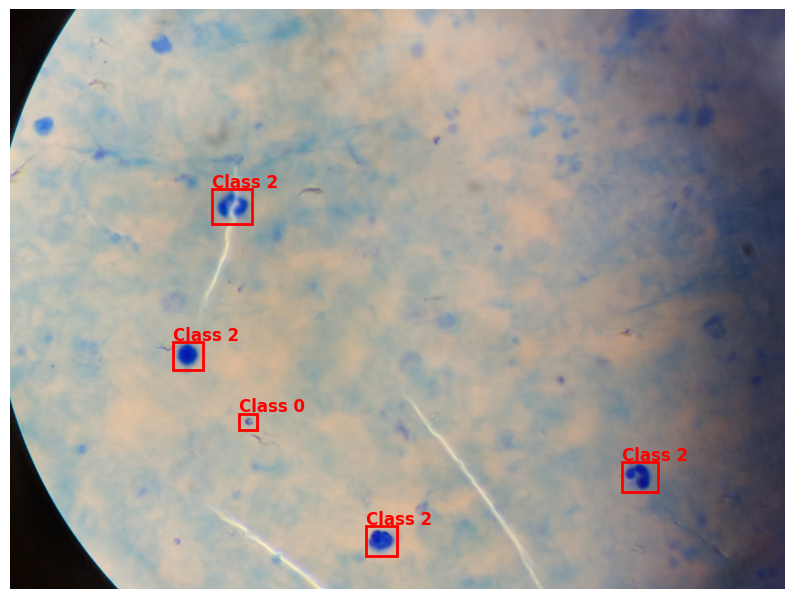

Plotting id_fu682pu2sa.jpg with 5 bounding boxes.


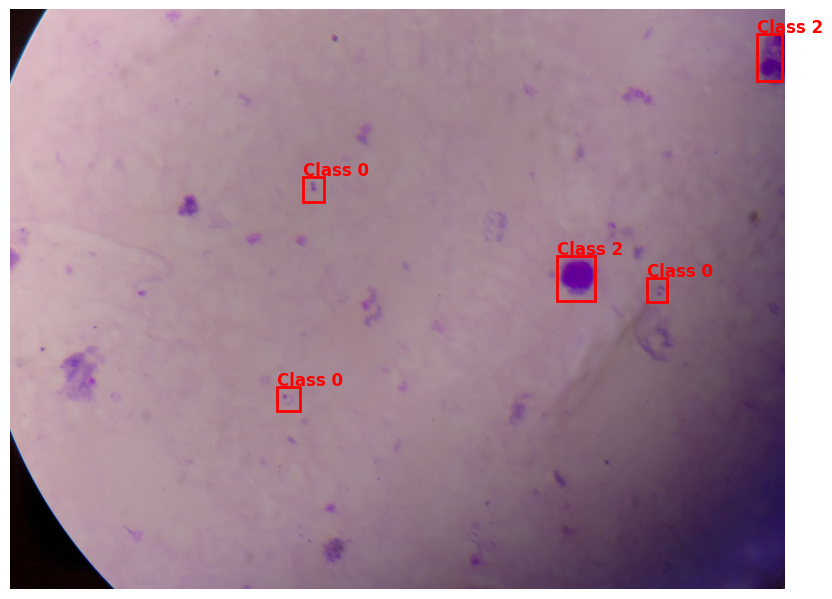

Plotting id_paub672i7v.jpg with 8 bounding boxes.


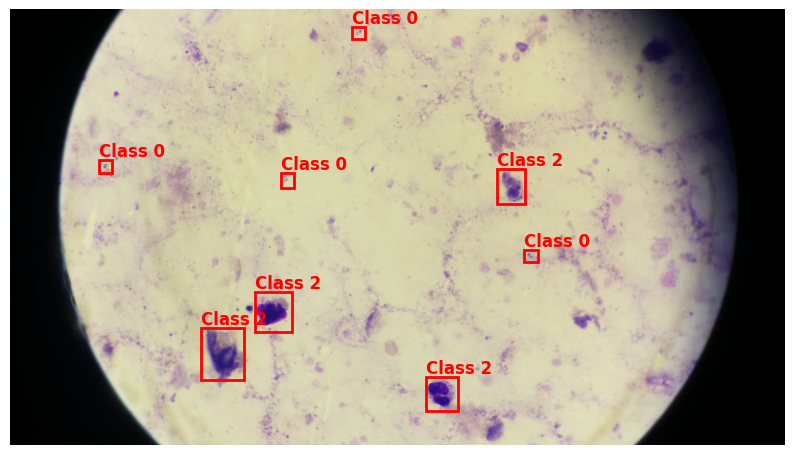

In [19]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")

In [20]:
# Load a YOLO pretrained model
model = YOLO('yolo11m.pt')

model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=50,                 # Number of epochs
    imgsz=1120,                # Image size
    batch=8,                   # Batch size
    device=0,                  # Use the first GPU (0 for the first GPU)
    patience=10,               # Number of epochs with no improvement after which training will stop
)


# model.train(
#     data='data.yaml',
#     epochs=20,
#     imgsz=1024,
#     batch=8,
#     device='0',
#     lr0=0.00999,
#     optimizer='Adam',
#     weight_decay=0.009,
#     augment=True,
#     scale=0.5,
#     patience=5
# )



# Validate the model on the validation seta
model.val()



100%|██████████| 38.8M/38.8M [00:00<00:00, 277MB/s]


Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=1120, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]
2024-11-15 15:23:18,653	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-15 15:23:19,206	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 2060 images, 516 backgrounds, 0 corrupt: 100%|██████████| 2060/2060 [00:02<00:00, 868.26it/s]

train: WARNING ⚠️ /kaggle/working/train/images/id_5bbz3srksa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_8l8zssuabc.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_8y0uii4k60.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_a6cl90trri.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_fzogq9kijh.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_i4d0ulpq39.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_i7r9hkhxvx.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_nzkpf8tr8o.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_qvc2le9sm8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/id_ytq3slqkjm.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/val/labels... 687 images, 172 backgrounds, 0 corrupt: 100%|██████████| 687/687 [00:00<00:00, 865.35it/s]

val: New cache created: /kaggle/working/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1120 train, 1120 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        14G      1.919      2.051      1.289        110       1120: 100%|██████████| 258/258 [05:01<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:25<00:00,  1.66it/s]

                   all        687       5778      0.434      0.563      0.449      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.9G      1.822       1.54      1.257         51       1120: 100%|██████████| 258/258 [04:57<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]

                   all        687       5778      0.417      0.628      0.571       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.9G      1.798      1.439      1.242         22       1120: 100%|██████████| 258/258 [04:57<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.79it/s]

                   all        687       5778      0.549      0.647      0.602      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.8G      1.778      1.422      1.234         45       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]

                   all        687       5778      0.611      0.608      0.605      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.8G      1.753      1.353       1.21         55       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]

                   all        687       5778      0.656      0.671      0.676      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.8G      1.725      1.318      1.201         35       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:25<00:00,  1.70it/s]

                   all        687       5778      0.713      0.755      0.748      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.8G      1.703      1.239        1.2         38       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]

                   all        687       5778      0.678      0.648       0.68      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.9G      1.717      1.243       1.19         70       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.78it/s]

                   all        687       5778      0.651      0.743      0.719      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.8G      1.721      1.241      1.198         39       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:25<00:00,  1.69it/s]

                   all        687       5778       0.67      0.735      0.741       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.8G      1.684      1.193      1.181         37       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]

                   all        687       5778      0.703      0.711      0.729      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      14.5G      1.686      1.173      1.183         35       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]

                   all        687       5778      0.696      0.749      0.745       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.9G      1.674      1.148      1.175         24       1120: 100%|██████████| 258/258 [04:56<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]

                   all        687       5778      0.593      0.686      0.666      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.8G      1.692      1.247      1.153        127       1120:   9%|▉         | 23/258 [00:26<04:29,  1.15s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      14/50      13.8G      1.692      1.247      1.153        127       1120:   9%|▉         | 23/258 [00:26<04:34,  1.17s/it]


KeyboardInterrupt: 

In [ ]:
# Make predictions on test images and save them to a CSV file
image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)
    results = model(img_path)

    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    confidences = results[0].boxes.conf.tolist()
    names = results[0].names
    incorrect_prediction = 0
    
    if not boxes:
        incorrect_prediction += 1
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,
            'ymin': 0,
            'xmin': 0,
            'ymax': 0,
            'xmax': 0
        })
    else:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]

            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    print(f"Incorrect predictions are {incorrect_prediction}")
# Convert the results to a DataFrame and save it
sub = pd.DataFrame(all_data)
sub.to_csv('/kaggle/working/yolo8_benchmark_submission.csv', index=False)

In [ ]:
sub

@article{wang2024yolov9,
  title={YOLOv9: Learning What You Want to Learn Using Programmable Gradient Information},
  author={Wang, Chien-Yao  and Liao, Hong-Yuan Mark},
  booktitle={arXiv preprint arXiv:2402.13616},
  year={2024}
}